In [1]:
#JANATA HACK CUSTOMER SEGMENTATION 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.model_selection import KFold
import lightgbm as lgb
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

In [70]:
#importing the dataset
train = pd.read_csv('Train_aBjfeNk.csv')
test = pd.read_csv('Test_LqhgPWU.csv')

#Combining the data
data = train.append(test)
data.shape

(10695, 11)

# EDA

In [7]:
data.head()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
1,462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4,A
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B
3,461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,B
4,462669,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,Cat_6,A


In [5]:
data.dtypes

ID                   int64
Gender              object
Ever_Married        object
Age                  int64
Graduated           object
Profession          object
Work_Experience    float64
Spending_Score      object
Family_Size        float64
Var_1               object
Segmentation        object
dtype: object

In [6]:
#Checking null counts
data.isna().sum()

ID                    0
Gender                0
Ever_Married        190
Age                   0
Graduated           102
Profession          162
Work_Experience    1098
Spending_Score        0
Family_Size         448
Var_1               108
Segmentation       2627
dtype: int64

Univariate Analysis

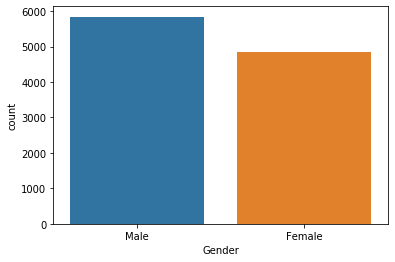

In [9]:
#Univariate analysis

sns.countplot('Gender',data=data)

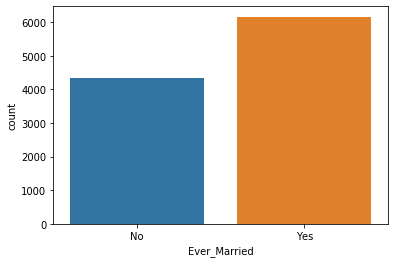

In [10]:
#Ever married:
sns.countplot('Ever_Married', data=data)

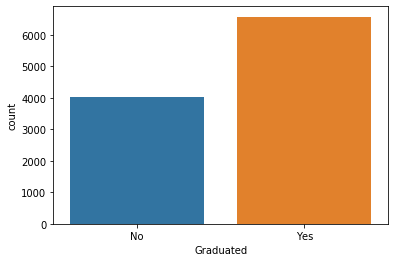

In [11]:
#Graduated: 
sns.countplot('Graduated', data=data)

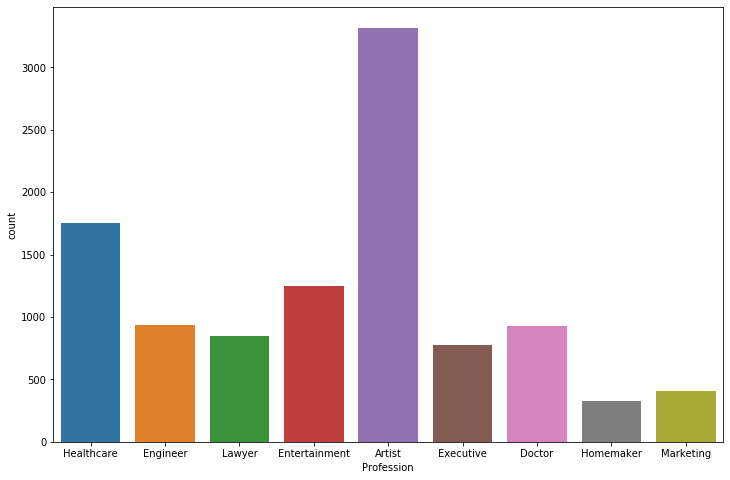

In [13]:
#Profession
plt.figure(figsize=(12,8))
sns.countplot('Profession', data=data)

#Most popular profession is art profession, followed by healthcare. Homemaker is the least popular profession.

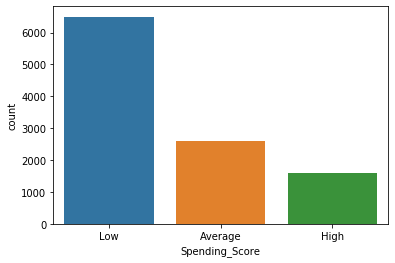

In [15]:
#Spending score
sns.countplot('Spending_Score', data=data)

#most are low spenders while the least set belong to high spenders

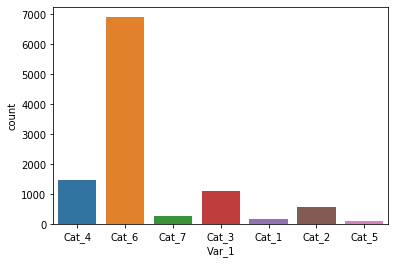

In [16]:
#Category Var distribution
sns.countplot('Var_1', data=data)

#Category 6 is BY FAR the most popular category

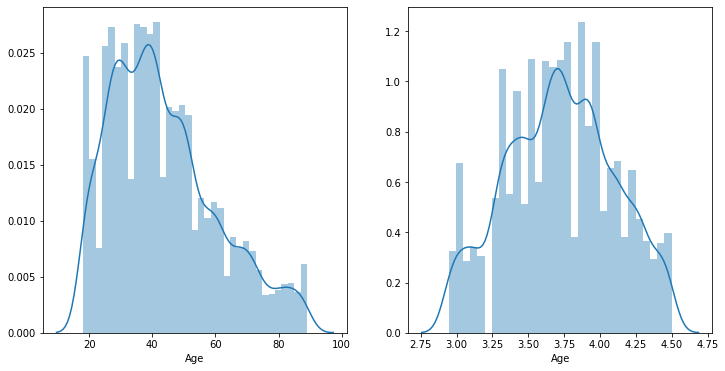

In [23]:
#Age
plt.figure(figsize=(12,6))

plt.subplot(121)
sns.distplot(data['Age'])

plt.subplot(122)
sns.distplot(np.log1p(data['Age']))
plt.show()

#logged age is more normal

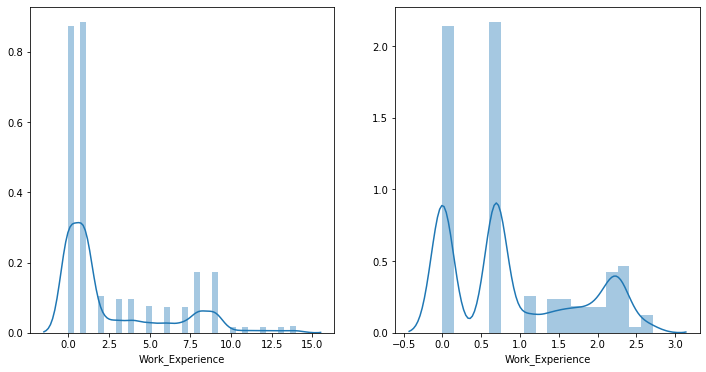

In [24]:
#Work Experience 
plt.figure(figsize=(12,6))

plt.subplot(121)
sns.distplot(data['Work_Experience'])

plt.subplot(122)
sns.distplot(np.log1p(data['Work_Experience']))
plt.show()

#logged work exp is bimodal

In [25]:
#Work exp
data['Work_Experience'].unique()

array([ 1., nan,  0.,  4.,  9., 12.,  3., 13.,  5.,  8., 14.,  7.,  2.,
        6., 10., 11.])

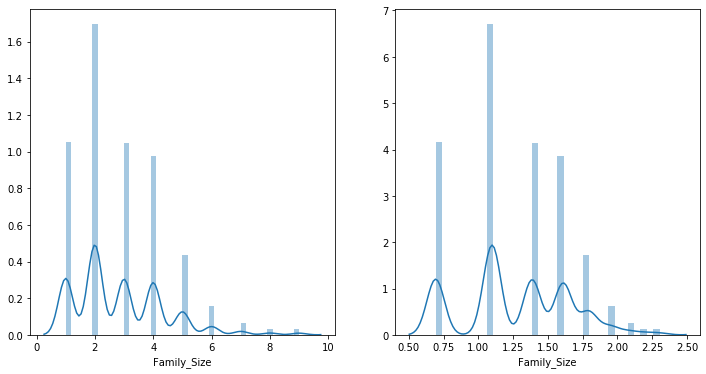

In [27]:
#Family Size
plt.figure(figsize=(12,6))

plt.subplot(121)
sns.distplot(data['Family_Size'])

plt.subplot(122)
sns.distplot(np.log1p(data['Family_Size']))
plt.show()



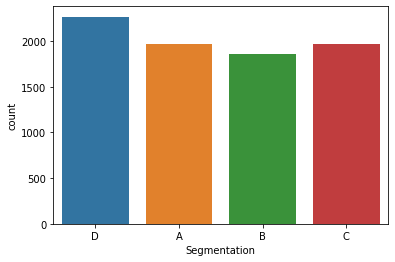

In [30]:
#Target var: Segmentation
sns.countplot('Segmentation',data=data)

#Almost equally distributed, with Segment D edging out the others, and B being last.

BIVARIATE ANALYSIS

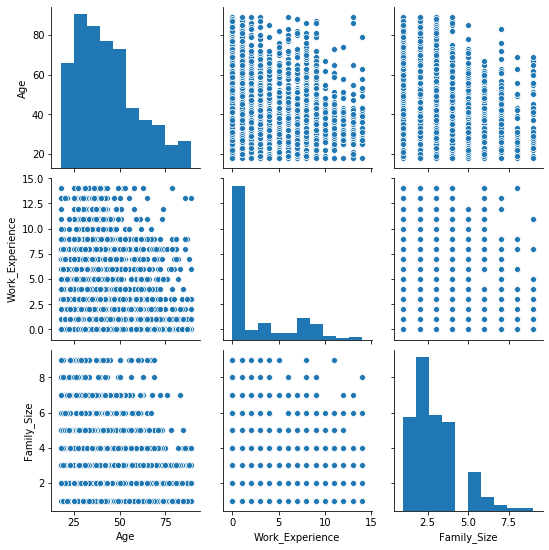

In [32]:
#BIVARIATE ANALYSIS
sns.pairplot(train.drop('ID',axis=1))

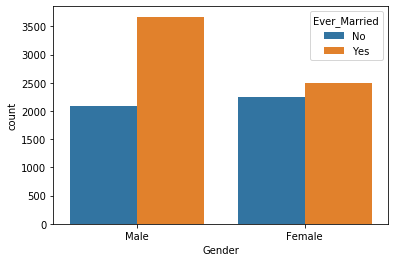

In [34]:
#Gender x Ever married
sns.countplot('Gender', hue='Ever_Married',data=data)

#Males have a higher difference between married and single peeps compared to females.

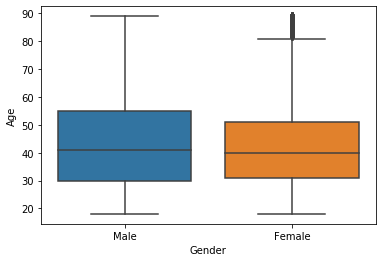

In [37]:
# Gender x Age
sns.boxplot(x='Gender',y='Age',data=data)

#Males have a higher age spread compared to the females. However, a lot of higher aged females (outliers) have purchased. 
#Median age is nearly same, with male median age just a tad bit higher   

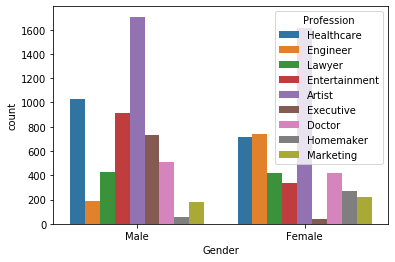

In [38]:
# Gender x Profession
sns.countplot('Gender', hue='Profession', data=data)

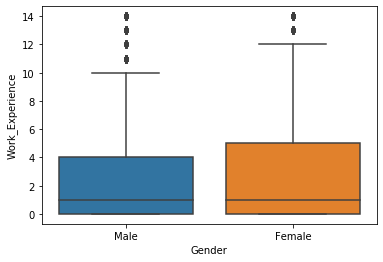

In [40]:
# Gender x Work exp
sns.boxplot(x='Gender',y='Work_Experience',data=data)

# A lot more women have work exp higher than median women work exp than the males. 

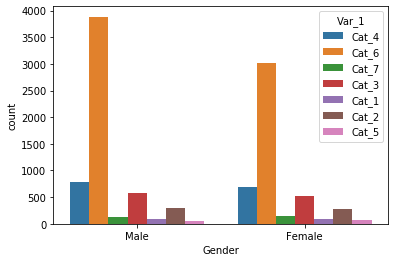

In [43]:
#Gender x Var
sns.countplot('Gender', hue='Var_1', data=data)

#No relation between genders and a specific category: it is same for both genders

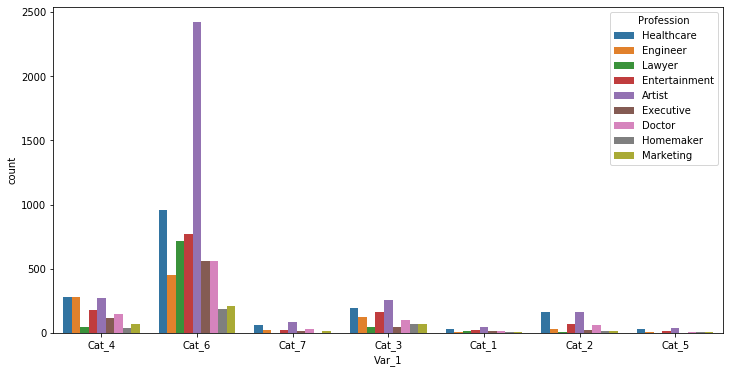

In [80]:
#Profession x cat
plt.figure(figsize=(12,6))
sns.countplot('Var_1', hue='Profession', data=data)

####Cat4 is not dominated by artist, but shares top postion jointly with healthcare and engineer professions

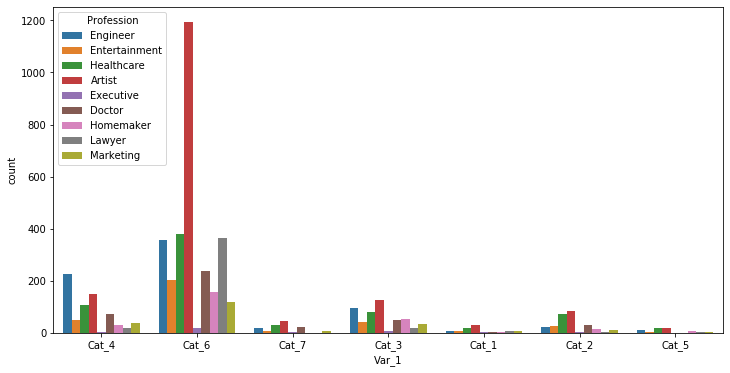

In [244]:
#Profession x cat
plt.figure(figsize=(12,6))
sns.countplot('Var_1', hue='Profession', data=data[data['Gender']=='Female'])

####Cat3 has significant number of female homemakers compared to the other categories. Could not find any significant insight for male homemakers


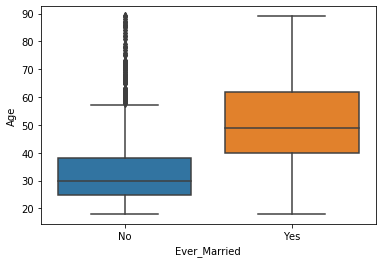

In [57]:
#Ever married x age
sns.boxplot(x='Ever_Married',y='Age', data=data)    

#As expected, median age of married customers is higher comp to unmarried. Also, unmarried customers have a lot of outliers


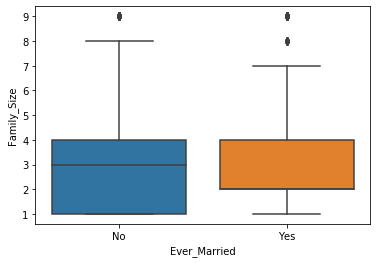

In [59]:
#Ever Married x Family Size
sns.boxplot(x='Ever_Married',y='Family_Size',data=data)

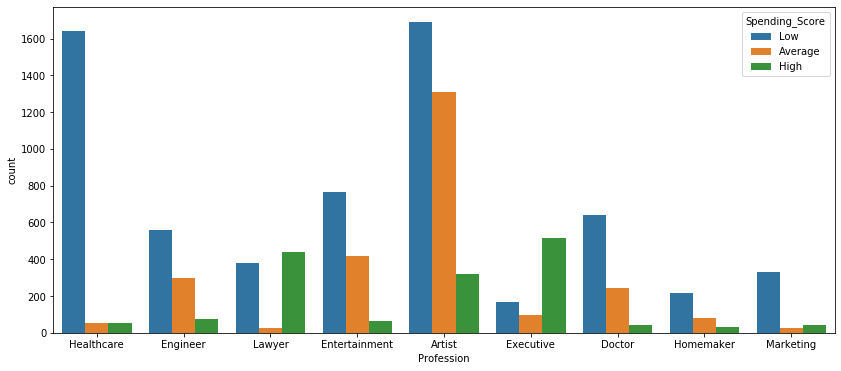

In [62]:
#Profession x spending score
plt.figure(figsize=(14,6))
sns.countplot('Profession', hue='Spending_Score', data=data)

#### Executive and lawyers have more high spenders than low/average

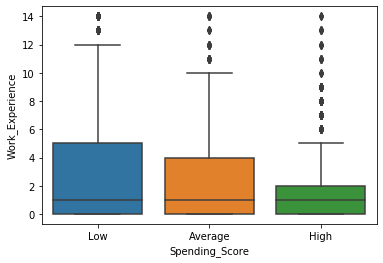

In [68]:
# Work exp x spending score
sns.boxplot(x='Spending_Score', y='Work_Experience', data=data)

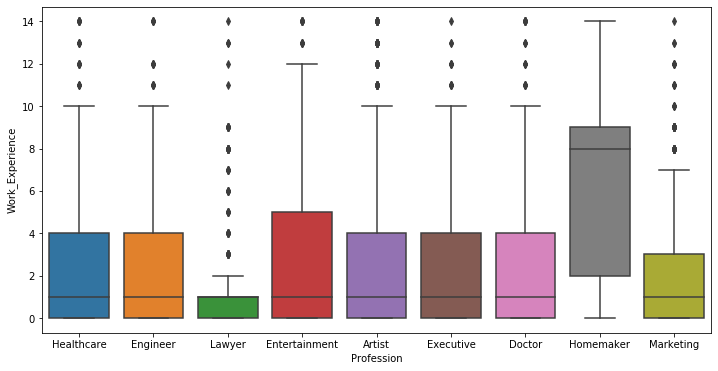

In [70]:
# Profession x work rxp
plt.figure(figsize=(12,6))
sns.boxplot(x='Profession', y='Work_Experience', data=data)

#Lawyers seem to have a low median work exp (and also a low spread), and homemakers have a very high median work exp


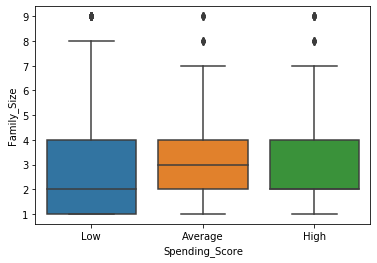

In [71]:
#SPENDING SCORE MAY BE DIRECTLY RELATED TO WORK EXP AND ALSO FAMILY SIZE. CHECK THAT.

#Spending score x Family size 
sns.boxplot(x='Spending_Score', y='Family_Size', data=data)

In [77]:
data.groupby('Spending_Score')['Family_Size'].agg(['count','min','max','mean','median','std'])
#Low spending scores have the least mean family size, as one might have guessed. Average > High in mean fam size

,count,min,max,mean,median,std
Spending_Score,,,,,,
Average,2555,1.0,9.0,3.095890,3.0,1.222266
High,1565,1.0,9.0,2.976358,2.0,1.352776
Low,6127,1.0,9.0,2.705239,2.0,1.675702


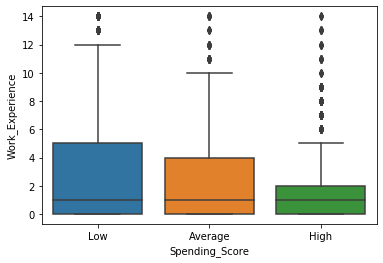

In [72]:
#Spending score x Work exp 
sns.boxplot(x='Spending_Score', y='Work_Experience', data=data)

####Surprisingly, high spending score customers have nearly the same median as low and avg spenders

In [76]:
data.groupby('Spending_Score')['Work_Experience'].agg(['count','min','max','mean','median','std'])

####confirmed. Diff spending scores same median work exp indicating spending scores may not be related to work exp as directly as I thought?
####In fact, the mean work exp is in order low>avg>high. Negative correlation?

,count,min,max,mean,median,std
Spending_Score,,,,,,
Average,2330,0.0,14.0,2.454077,1.0,3.174040
High,1399,0.0,14.0,2.111508,1.0,2.993389
Low,5868,0.0,14.0,2.806748,1.0,3.544474


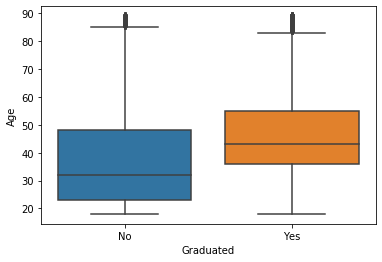

In [81]:
# Graduated x age
sns.boxplot(x='Graduated', y='Age', data=data)

#Obviously, graduated customers have a higher mean age than non-graduated customers

In [82]:
data.groupby('Graduated')['Age'].agg(['count','min','max','mean','median','std'])


,count,min,max,mean,median,std
Graduated,,,,,,
No,4023,18,89,38.442953,32,18.405353
Yes,6570,18,89,46.578843,43,14.814167


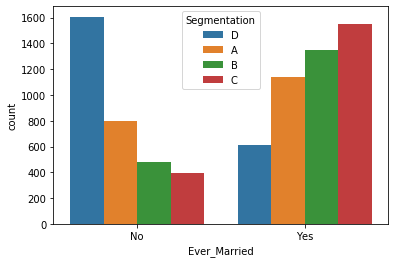

In [85]:
#Target var: Segmentation

#Seg x Ever Married
sns.countplot('Ever_Married', hue='Segmentation', data=data)

#### Unmarried Customers and married customers actually have a mirrored distribution into the categories
#### D>A>B>C for unmarried and D<A<B<C for married customers

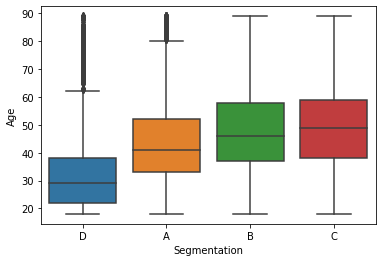

In [88]:
#Seg x age
sns.boxplot(x='Segmentation', y='Age', data=data)

#### D<A<B<C w.r.t age 
#### D targets mostly younger customers, and C mostly the older customers. This is also confirmed by above plot, where we can see that
   # for married customers, C is the most popular segment (because married peeps are usually older as we had seen) and 
   # for unmarried customers, D is the most popular segment (because unmarried peeps had a lower med/mean age as seen)

In [89]:
data.groupby('Segmentation')['Age'].agg(['count','min','max','mean','median','std'])


,count,min,max,mean,median,std
Segmentation,,,,,,
A,1972,18,89,44.924949,41,16.406909
B,1858,18,89,48.200215,46,14.806443
C,1970,18,89,49.144162,49,14.575090
D,2268,18,89,33.390212,29,15.680304


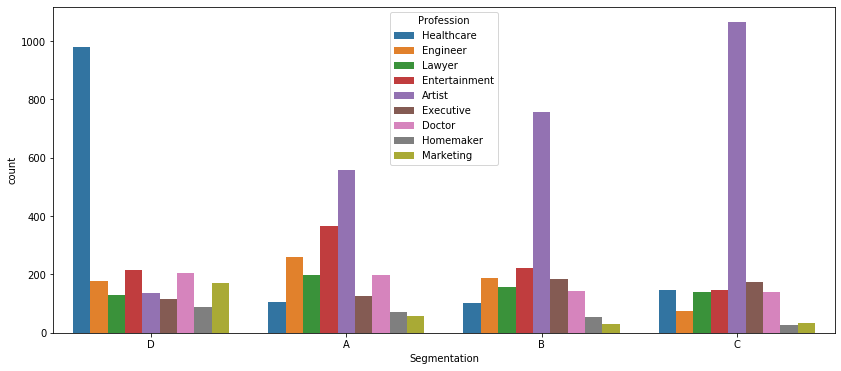

In [92]:
####Segmentation should ideally have a correlation with profession solely because they are independently correlated to spending score?

#Seg vs profession
plt.figure(figsize=(14,6))
sns.countplot('Segmentation',hue='Profession',data=data)

####Segment D has healthcare as the most popular profession, while the rest have artist as the most popular profession
#### D is also the most popular segment for lesser age. 

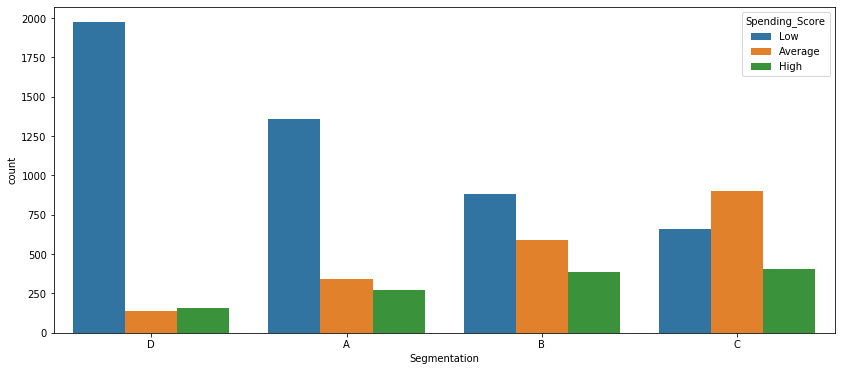

In [96]:
#Seg vs Spending Score
plt.figure(figsize=(14,6))
sns.countplot('Segmentation',hue='Spending_Score',data=data)

#Segment C has highest average spending customers and the remaining have highest low spending customers.

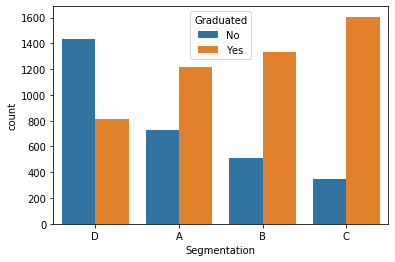

In [98]:
sns.countplot('Segmentation',hue='Graduated',data=data)

####D again has higher non graduated (students) than graduated (remaining have opposite figures) 
#further pointing to the fact that segment D is mostly for younger people

# Feature Engineering

In [3]:
#imputing missing values first
data.isna().sum()    

ID                    0
Gender                0
Ever_Married        190
Age                   0
Graduated           102
Profession          162
Work_Experience    1098
Spending_Score        0
Family_Size         448
Var_1               108
Segmentation       2627
dtype: int64

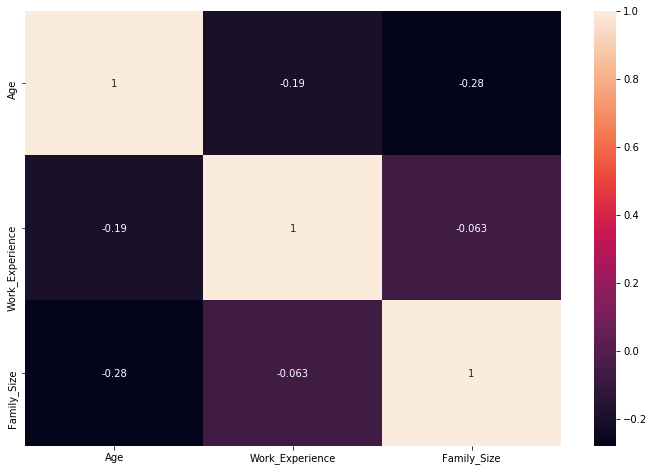

In [105]:
#correlation plot
train2 = train.copy()
train2.drop(['ID'],inplace=True,axis=1)
plt.figure(figsize=(12,8))
cmap = train2.corr()
sns.heatmap(cmap, annot=True)

In [106]:
train2 = pd.get_dummies(data=train2, columns={'Gender', 'Ever_Married', 'Graduated', 'Profession'})


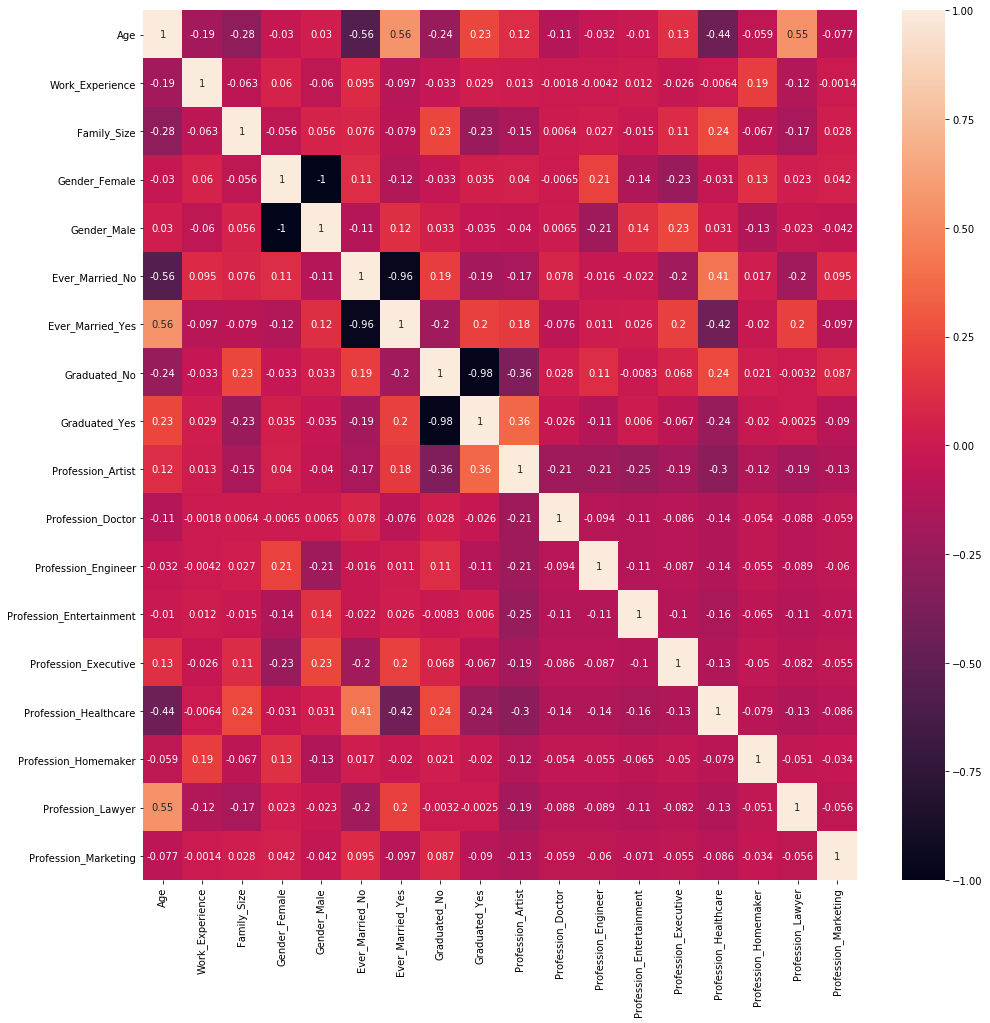

In [107]:
cmap2 = train2.corr()
plt.figure(figsize=(16,16))
sns.heatmap(cmap2, annot=True)

In [110]:
#Age is highly correlated to Ever married.
data.groupby('Ever_Married')['Age'].agg(['count','min','max','mean','median','std'])


,count,min,max,mean,median,std
Ever_Married,,,,,,
No,4342,18,89,32.165131,30,10.710496
Yes,6163,18,89,51.552815,49,15.599486


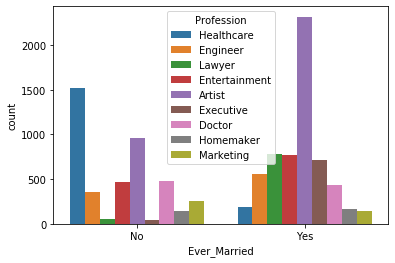

In [109]:
#Also, Ever married NO is highly positively correlated to Healthcare, while Ever married YES is highly negatively correlated to healthcare
#This can be confirmed by the below plot: No has a very high healthcare profession count, the opposite for yes.
sns.countplot('Ever_Married', hue='Profession', data=data)

In [71]:
#Imputing Ever married only using age: for missing ever married with profession healthcare, all but 4-5 records are 
#getting correctly imputed by taking mean, so it is easier to just take the mean age imputation 

data.loc[(data['Ever_Married'].isna()) & (data['Age']<33), 'Ever_Married'] = 'No'
data.loc[(data['Ever_Married'].isna()) & (data['Age']>=33), 'Ever_Married'] = 'Yes'

In [72]:
data.isna().sum()

ID                    0
Gender                0
Ever_Married          0
Age                   0
Graduated           102
Profession          162
Work_Experience    1098
Spending_Score        0
Family_Size         448
Var_1               108
Segmentation       2627
dtype: int64

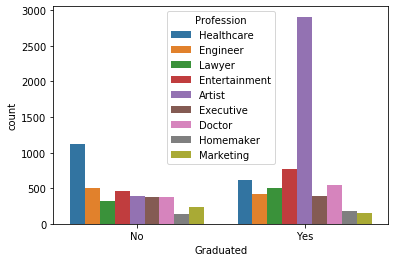

In [126]:
# GRADUATED

#graduated highly corr with: artist, healthcare, age, family size, ever married
 
sns.countplot('Graduated', hue='Profession', data=data)    

In [135]:
#GRAD VS AGE
#sns.boxplot(x='Graduated', y='Age', data=data) 
data.groupby(['Graduated'])['Age'].agg(['count','min','max','mean','median','std'])

,count,min,max,mean,median,std
Graduated,,,,,,
No,4023,18,89,38.442953,32,18.405353
Yes,6570,18,89,46.578843,43,14.814167


In [73]:
#IMPUTING GRADUATED WITH JUST AGE 
data.loc[(data['Graduated'].isna()) & (data['Age'] < 39), 'Graduated'] = 'No'
data.loc[(data['Graduated'].isna()) & (data['Age'] >= 39), 'Graduated'] = 'Yes'

In [7]:
data.isna().sum()


ID                    0
Gender                0
Ever_Married          0
Age                   0
Graduated             0
Profession          162
Work_Experience    1098
Spending_Score        0
Family_Size         448
Var_1               108
Segmentation       2627
dtype: int64

In [74]:
# PROFESSION

#profession was somewhat correlated to Spending score, so we can use that to impute missing professions. 
#data.groupby(['Spending_Score', 'Profession'])['Profession'].agg(['count'])

#Imputing profession with just Artist
data['Profession'] = data['Profession'].fillna('Artist')
data.isna().sum()

ID                    0
Gender                0
Ever_Married          0
Age                   0
Graduated             0
Profession            0
Work_Experience    1098
Spending_Score        0
Family_Size         448
Var_1               108
Segmentation       2627
dtype: int64

In [157]:
data.isna().sum()

ID                    0
Gender                0
Ever_Married          0
Age                   0
Graduated             0
Profession          162
Work_Experience    1098
Spending_Score        0
Family_Size         448
Var_1               108
Segmentation       2627
dtype: int64

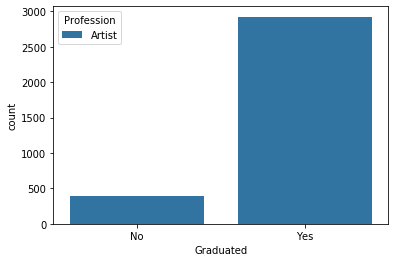

In [161]:
sns.countplot('Graduated', hue='Profession', data=data[data['Profession']=='Artist'])

In [163]:
data.isna().sum()

ID                    0
Gender                0
Ever_Married          0
Age                   0
Graduated             0
Profession            0
Work_Experience    1098
Spending_Score        0
Family_Size         448
Var_1               108
Segmentation       2627
dtype: int64

In [167]:
data.groupby('Work_Experience')['Age'].agg({'count','min','max','mean','median'})

,min,max,median,count,mean
Work_Experience,,,,,
0.0,18,89,43.0,3087,45.350826
1.0,18,89,45.0,3127,46.152862
2.0,18,89,41.0,373,42.938338
3.0,18,89,40.0,337,41.356083
4.0,18,89,40.0,346,41.124277
5.0,18,85,38.0,270,39.562963
6.0,18,89,38.0,265,38.932075
7.0,18,89,37.0,256,39.109375
8.0,18,86,36.5,612,37.619281


In [172]:
data.groupby('Profession')['Work_Experience'].agg({'count','min','max','mean','median'})

,min,max,median,count,mean
Profession,,,,,
Artist,0.0,14.0,1.0,3174,2.667927
Doctor,0.0,14.0,1.0,850,2.595294
Engineer,0.0,14.0,1.0,842,2.606888
Entertainment,0.0,14.0,1.0,1134,2.751323
Executive,0.0,14.0,1.0,684,2.321637
Healthcare,0.0,14.0,1.0,1558,2.556483
Homemaker,0.0,14.0,8.0,277,6.440433
Lawyer,0.0,14.0,1.0,726,1.236915
Marketing,0.0,14.0,1.0,352,2.556818


In [75]:
# Imputing mean work exp of the respective professions into the missing work exps
data['Work_Experience'] = data['Work_Experience'].fillna(data.groupby(['Profession'])['Work_Experience'].transform('mean'))

In [76]:
# AGE BRACKETS
datac = data.copy()
data['Age_Brackets'] = pd.qcut(x=data['Age'],q=3, labels=['aLow','bMedium','cHigh'])


In [77]:
data.groupby('Age_Brackets')['Age'].agg({'min','max','count'})

,count,max,min
Age_Brackets,,,
aLow,3882,35,18
bMedium,3428,49,36
cHigh,3385,89,50


In [11]:
data.isna().sum()

ID                    0
Gender                0
Ever_Married          0
Age                   0
Graduated             0
Profession            0
Work_Experience       0
Spending_Score        0
Family_Size         448
Var_1               108
Segmentation       2627
Age_Brackets          0
dtype: int64

In [226]:
# FAMILY SIZE
data.groupby('Family_Size').count()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Var_1,Segmentation,Age_Brackets
Family_Size,,,,,,,,,,,
1.0,1965,1965,1965,1965,1965,1965,1965,1965,1947,1453,1965
2.0,3158,3158,3158,3158,3158,3158,3158,3158,3133,2390,3158
3.0,1952,1952,1952,1952,1952,1952,1952,1952,1936,1497,1952
4.0,1823,1823,1823,1823,1823,1823,1823,1823,1807,1379,1823
5.0,812,812,812,812,812,812,812,812,798,612,812
6.0,290,290,290,290,290,290,290,290,290,212,290
7.0,122,122,122,122,122,122,122,122,122,96,122
8.0,65,65,65,65,65,65,65,65,65,50,65
9.0,60,60,60,60,60,60,60,60,60,44,60


In [227]:
data.groupby('Graduated')['Family_Size'].agg({'count','min','max','mean','median'})

,min,max,median,count,mean
Graduated,,,,,
No,1.0,9.0,3.0,3855,3.321401
Yes,1.0,9.0,2.0,6392,2.556164


In [230]:
data.groupby('Age_Brackets')['Family_Size'].agg({'count','min','max','mean','median'})

,min,max,median,count,mean
Age_Brackets,,,,,
aLow,1.0,9.0,3.0,3692,3.381907
bMedium,1.0,9.0,2.0,3305,2.594856
cHigh,1.0,9.0,2.0,3250,2.486462


In [78]:
# Imputing family size with mean of age brackets
data.loc[(data['Family_Size'].isna()) & (data['Age_Brackets'] == 'aLow'), 'Family_Size'] = 3.0
data.loc[(data['Family_Size'].isna()) & (data['Age_Brackets'] == 'bMedium'), 'Family_Size'] = 2.0
data.loc[(data['Family_Size'].isna()) & (data['Age_Brackets'] == 'cHigh'), 'Family_Size'] = 2.0

In [79]:
data.isna().sum()

ID                    0
Gender                0
Ever_Married          0
Age                   0
Graduated             0
Profession            0
Work_Experience       0
Spending_Score        0
Family_Size           0
Var_1               108
Segmentation       2627
Age_Brackets          0
dtype: int64

In [80]:
#Imputing Var_1 with modal cat
data['Var_1'] = data['Var_1'].fillna('Cat_6')
data.groupby('Var_1')['Age'].agg({'min','max','count','mean','median'})

,count,max,mean,median,min
Var_1,,,,,
Cat_1,167,73,39.784431,38,18
Cat_2,563,89,37.298401,36,18
Cat_3,1089,89,39.339761,38,18
Cat_4,1475,88,39.149153,37,18
Cat_5,114,78,36.666667,33,18
Cat_6,7018,89,45.949416,43,18
Cat_7,269,87,38.947955,37,18


In [247]:
data.isna().sum()

ID                    0
Gender                0
Ever_Married          0
Age                   0
Graduated             0
Profession            0
Work_Experience       0
Spending_Score        0
Family_Size           0
Var_1                 0
Segmentation       2627
Age_Brackets          0
dtype: int64

In [81]:
# Family size bins
data2 = data.copy()

def fm_size(x):
    if 1 <= x <= 2:
        return 'aSmall'
    elif 3 <= x <= 5:
        return 'bMedium'
    else:
        return 'cLarge'
    

data['Family_Size_Brackets'] = data['Family_Size'].apply(fm_size)
data

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation,Age_Brackets,Family_Size_Brackets
0,462809,Male,No,22,No,Healthcare,1.000000,Low,4.0,Cat_4,D,aLow,bMedium
1,462643,Female,Yes,38,Yes,Engineer,2.606888,Average,3.0,Cat_4,A,bMedium,bMedium
2,466315,Female,Yes,67,Yes,Engineer,1.000000,Low,1.0,Cat_6,B,cHigh,aSmall
3,461735,Male,Yes,67,Yes,Lawyer,0.000000,High,2.0,Cat_6,B,cHigh,aSmall
4,462669,Female,Yes,40,Yes,Entertainment,2.751323,High,6.0,Cat_6,A,bMedium,cLarge
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2622,467954,Male,No,29,No,Healthcare,9.000000,Low,4.0,Cat_6,NaN,aLow,bMedium
2623,467958,Female,No,35,Yes,Doctor,1.000000,Low,1.0,Cat_6,NaN,aLow,aSmall
2624,467960,Female,No,53,Yes,Entertainment,2.751323,Low,2.0,Cat_6,NaN,cHigh,aSmall
2625,467961,Male,Yes,47,Yes,Executive,1.000000,High,5.0,Cat_4,NaN,bMedium,bMedium


In [253]:
data.groupby('Family_Size_Brackets')['Family_Size'].agg({'min','max'})

,min,max
Family_Size_Brackets,,
Large,6.0,9.0
Medium,3.0,5.0
Small,1.0,2.0


In [82]:
# Work exp bins
data['Work_Experience'] = round(data['Work_Experience'])

def work_exp(x):
    if x < 3:
        return 'aLow'
    elif 3 <= x <= 6:
        return 'bMedium'
    else:
        return 'cHigh'

data['Work_exp_brackets'] = data['Work_Experience'].apply(work_exp)    
data        
        

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation,Age_Brackets,Family_Size_Brackets,Work_exp_brackets
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D,aLow,bMedium,aLow
1,462643,Female,Yes,38,Yes,Engineer,3.0,Average,3.0,Cat_4,A,bMedium,bMedium,bMedium
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B,cHigh,aSmall,aLow
3,461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,B,cHigh,aSmall,aLow
4,462669,Female,Yes,40,Yes,Entertainment,3.0,High,6.0,Cat_6,A,bMedium,cLarge,bMedium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2622,467954,Male,No,29,No,Healthcare,9.0,Low,4.0,Cat_6,NaN,aLow,bMedium,cHigh
2623,467958,Female,No,35,Yes,Doctor,1.0,Low,1.0,Cat_6,NaN,aLow,aSmall,aLow
2624,467960,Female,No,53,Yes,Entertainment,3.0,Low,2.0,Cat_6,NaN,cHigh,aSmall,bMedium
2625,467961,Male,Yes,47,Yes,Executive,1.0,High,5.0,Cat_4,NaN,bMedium,bMedium,aLow


In [84]:
data['Work_Experience'].unique()

array([ 1.,  3.,  0.,  4.,  9., 12., 13.,  5.,  8., 14.,  7.,  6.,  2.,
       10., 11.])

In [18]:
data.groupby('Work_exp_brackets')['Work_Experience'].agg({'min','max','count'})

,count,max,min
Work_exp_brackets,,,
aLow,6796,2.0,0.0
bMedium,2107,6.0,3.0
cHigh,1792,14.0,7.0


In [85]:
# CREATE A COPY OF THE DATA 
data_copy = data.copy()

In [86]:
#OHE AND LE
data['Spending_Score'] = data['Spending_Score'].replace('Low', 'aLow')
data['Spending_Score'] = data['Spending_Score'].replace('Average', 'bAverage')
data['Spending_Score'] = data['Spending_Score'].replace('High', 'cHigh')

le = LabelEncoder()
cols = ['Spending_Score', 'Age_Brackets', 'Family_Size_Brackets', 'Work_exp_brackets']
data
    

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation,Age_Brackets,Family_Size_Brackets,Work_exp_brackets
0,462809,Male,No,22,No,Healthcare,1.0,aLow,4.0,Cat_4,D,aLow,bMedium,aLow
1,462643,Female,Yes,38,Yes,Engineer,3.0,bAverage,3.0,Cat_4,A,bMedium,bMedium,bMedium
2,466315,Female,Yes,67,Yes,Engineer,1.0,aLow,1.0,Cat_6,B,cHigh,aSmall,aLow
3,461735,Male,Yes,67,Yes,Lawyer,0.0,cHigh,2.0,Cat_6,B,cHigh,aSmall,aLow
4,462669,Female,Yes,40,Yes,Entertainment,3.0,cHigh,6.0,Cat_6,A,bMedium,cLarge,bMedium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2622,467954,Male,No,29,No,Healthcare,9.0,aLow,4.0,Cat_6,NaN,aLow,bMedium,cHigh
2623,467958,Female,No,35,Yes,Doctor,1.0,aLow,1.0,Cat_6,NaN,aLow,aSmall,aLow
2624,467960,Female,No,53,Yes,Entertainment,3.0,aLow,2.0,Cat_6,NaN,cHigh,aSmall,bMedium
2625,467961,Male,Yes,47,Yes,Executive,1.0,cHigh,5.0,Cat_4,NaN,bMedium,bMedium,aLow


In [87]:
#LABEL ENCODING
for i in cols:
    data[i] = le.fit_transform(data[i])
data    

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation,Age_Brackets,Family_Size_Brackets,Work_exp_brackets
0,462809,Male,No,22,No,Healthcare,1.0,0,4.0,Cat_4,D,0,1,0
1,462643,Female,Yes,38,Yes,Engineer,3.0,1,3.0,Cat_4,A,1,1,1
2,466315,Female,Yes,67,Yes,Engineer,1.0,0,1.0,Cat_6,B,2,0,0
3,461735,Male,Yes,67,Yes,Lawyer,0.0,2,2.0,Cat_6,B,2,0,0
4,462669,Female,Yes,40,Yes,Entertainment,3.0,2,6.0,Cat_6,A,1,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2622,467954,Male,No,29,No,Healthcare,9.0,0,4.0,Cat_6,NaN,0,1,2
2623,467958,Female,No,35,Yes,Doctor,1.0,0,1.0,Cat_6,NaN,0,0,0
2624,467960,Female,No,53,Yes,Entertainment,3.0,0,2.0,Cat_6,NaN,2,0,1
2625,467961,Male,Yes,47,Yes,Executive,1.0,2,5.0,Cat_4,NaN,1,1,0


In [88]:
#One Hot encoding the other cat vars
ohecols = ['Gender','Ever_Married','Graduated','Profession','Var_1']
data = pd.get_dummies(data=data, columns = ohecols)
data

,ID,Age,Work_Experience,Spending_Score,Family_Size,Segmentation,Age_Brackets,Family_Size_Brackets,Work_exp_brackets,Gender_Female,...,Profession_Homemaker,Profession_Lawyer,Profession_Marketing,Var_1_Cat_1,Var_1_Cat_2,Var_1_Cat_3,Var_1_Cat_4,Var_1_Cat_5,Var_1_Cat_6,Var_1_Cat_7
0,462809,22,1.0,0,4.0,D,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
1,462643,38,3.0,1,3.0,A,1,1,1,1,...,0,0,0,0,0,0,1,0,0,0
2,466315,67,1.0,0,1.0,B,2,0,0,1,...,0,0,0,0,0,0,0,0,1,0
3,461735,67,0.0,2,2.0,B,2,0,0,0,...,0,1,0,0,0,0,0,0,1,0
4,462669,40,3.0,2,6.0,A,1,2,1,1,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2622,467954,29,9.0,0,4.0,NaN,0,1,2,0,...,0,0,0,0,0,0,0,0,1,0
2623,467958,35,1.0,0,1.0,NaN,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
2624,467960,53,3.0,0,2.0,NaN,2,0,1,1,...,0,0,0,0,0,0,0,0,1,0
2625,467961,47,1.0,2,5.0,NaN,1,1,0,0,...,0,0,0,0,0,0,1,0,0,0


# Model Building

In [278]:
data.dtypes

ID                            int64
Age                           int64
Work_Experience             float64
Spending_Score                int32
Family_Size                 float64
Segmentation                 object
Age_Brackets                  int32
Family_Size_Brackets          int32
Work_exp_brackets             int32
Gender_Female                 uint8
Gender_Male                   uint8
Ever_Married_No               uint8
Ever_Married_Yes              uint8
Graduated_No                  uint8
Graduated_Yes                 uint8
Profession_Artist             uint8
Profession_Doctor             uint8
Profession_Engineer           uint8
Profession_Entertainment      uint8
Profession_Executive          uint8
Profession_Healthcare         uint8
Profession_Homemaker          uint8
Profession_Lawyer             uint8
Profession_Marketing          uint8
Var_1_Cat_1                   uint8
Var_1_Cat_2                   uint8
Var_1_Cat_3                   uint8
Var_1_Cat_4                 

In [22]:
#Separating the train and test sets
trainf = data[data['Segmentation'].isna() == False]
testf = data[data['Segmentation'].isna()]
testf.drop('Segmentation', inplace=True, axis=1)
trainf.shape, testf.shape

D:\anaconda\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


((8068, 31), (2627, 30))

In [171]:
kf = StratifiedKFold(n_splits=10, shuffle=False, random_state=42)
y = trainf['Segmentation']
X = trainf[[col for col in trainf.columns if col!= "Segmentation" and col!="ID"]]
X.head()

D:\anaconda\lib\site-packages\sklearn\model_selection\_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


,Age,Work_Experience,Spending_Score,Family_Size,Age_Brackets,Family_Size_Brackets,Work_exp_brackets,Gender_Female,Gender_Male,Ever_Married_No,...,Profession_Homemaker,Profession_Lawyer,Profession_Marketing,Var_1_Cat_1,Var_1_Cat_2,Var_1_Cat_3,Var_1_Cat_4,Var_1_Cat_5,Var_1_Cat_6,Var_1_Cat_7
0,22,1.0,0,4.0,0,1,0,0,1,1,...,0,0,0,0,0,0,1,0,0,0
1,38,3.0,1,3.0,1,1,1,1,0,0,...,0,0,0,0,0,0,1,0,0,0
2,67,1.0,0,1.0,2,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
3,67,0.0,2,2.0,2,0,0,0,1,0,...,0,1,0,0,0,0,0,0,1,0
4,40,3.0,2,6.0,1,2,1,1,0,0,...,0,0,0,0,0,0,0,0,1,0


In [172]:

lgb1 = lgb.LGBMClassifier(boosting_type='gbdt', objective='multiclass', num_class=4, random_state=42,n_jobs=-1,verbose=1)
params = {"max_depth":[4,6,8,10,-1],
          "learning_rate":[0.01, 0.03, 0.05, 0.1, 0.3, 0.5, 0.7, 0.8, 0.9, 1, 1.1, 1.2, 1.5],
          "subsample":[0.5,0.6,0.7,0.8,0.9,1],
          "colsample_bytree":[0.5,0.6,0.7,0.8,0.9,1],
          "reg_alpha":[0,0.25,0.5,1,2],
          "reg_lambda":[0,0.25,0.5,1,2],
          "num_leaves":[7,15,31,63,127],
          "min_data_in_leaf":[1,3,5,7,10,25,50,75,100],
          "n_estimators":list(range(50,1001,25))
         }
random_searchlgb = RandomizedSearchCV(estimator=lgb1, param_distributions=params, cv=kf.split(X, y), scoring='accuracy')
#random_searchlgb.fit(X,y) 

In [ ]:
random_searchlgb.fit(X,y)

In [ ]:
random_searchlgb.best_estimator_,random_searchlgb.best_params_,random_searchlgb.best_score_


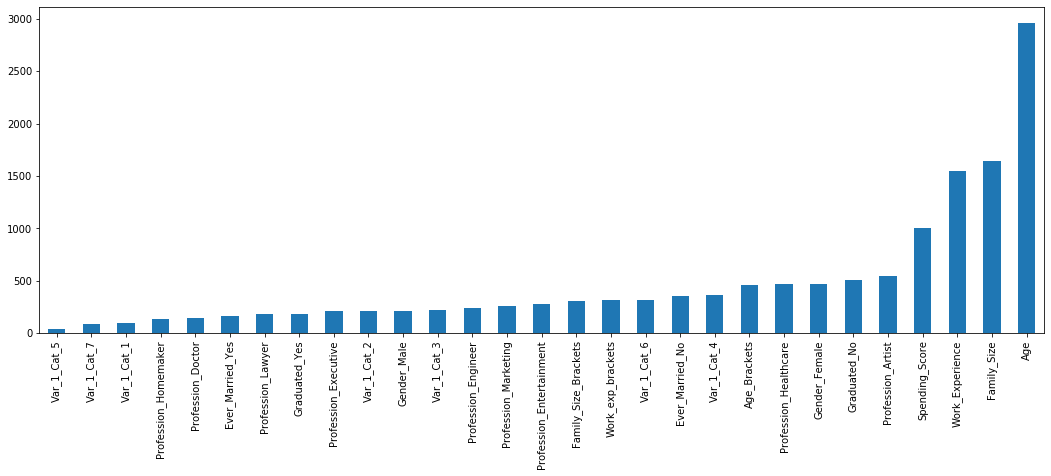

In [58]:
plt.figure(figsize=(18,6))
ser = pd.Series(random_searchlgb.best_estimator_.feature_importances_,X.columns).sort_values()
ser.plot(kind='bar')


In [55]:
submission = testf[['ID']]
submission.head()

,ID
0,458989
1,458994
2,458996
3,459000
4,459001


In [56]:

submission['Segmentation'] = random_searchlgb.best_estimator_.predict(testf.drop(['ID'],axis=1))
submission

D:\anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,ID,Segmentation
0,458989,A
1,458994,C
2,458996,B
3,459000,C
4,459001,D
...,...,...
2622,467954,D
2623,467958,A
2624,467960,A
2625,467961,B


In [57]:

submission.to_csv('LGBM.csv', index=None)

# RandomForest

In [47]:
kf = StratifiedKFold(n_splits=10, shuffle=False, random_state=42)
y = trainf['Segmentation']
X = trainf[[col for col in trainf.columns if col!= "Segmentation" and col!="ID"]]
X.head()

D:\anaconda\lib\site-packages\sklearn\model_selection\_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


,Age,Work_Experience,Spending_Score,Family_Size,Age_Brackets,Family_Size_Brackets,Work_exp_brackets,Gender_Female,Gender_Male,Ever_Married_No,...,Profession_Homemaker,Profession_Lawyer,Profession_Marketing,Var_1_Cat_1,Var_1_Cat_2,Var_1_Cat_3,Var_1_Cat_4,Var_1_Cat_5,Var_1_Cat_6,Var_1_Cat_7
0,22,1.0,0,4.0,0,1,0,0,1,1,...,0,0,0,0,0,0,1,0,0,0
1,38,3.0,1,3.0,1,1,1,1,0,0,...,0,0,0,0,0,0,1,0,0,0
2,67,1.0,0,1.0,2,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
3,67,0.0,2,2.0,2,0,0,0,1,0,...,0,1,0,0,0,0,0,0,1,0
4,40,3.0,2,6.0,1,2,1,1,0,0,...,0,0,0,0,0,0,0,0,1,0


In [48]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 200, num = 6)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 50, num = 10)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2,3,5,8, 10, 15]
# Minimum number of samples required at each leaf node
min_samples_leaf = [2, 4, 6, 8,10]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [50, 80, 110, 140, 170, 200], 'max_features': ['auto', 'sqrt'], 'max_depth': [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, None], 'min_samples_split': [2, 3, 5, 8, 10, 15], 'min_samples_leaf': [2, 4, 6, 8, 10], 'bootstrap': [True, False]}


In [49]:
#Grid search to find best parameter values
rf5 = RandomForestClassifier(random_state=3,n_jobs = -1)
rf_random = RandomizedSearchCV(estimator = rf5, param_distributions = random_grid, n_iter = 10, cv = kf.split(X, y), verbose=2, random_state=3, scoring = 'accuracy', n_jobs = -1)
# Fit the random search model
rf_random.fit(X, y)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   18.7s finished


RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x000002DF0637BB48>,
                   error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,...
                   

In [50]:
rf_random.best_params_, rf_random.best_score_ 

({'n_estimators': 110,
  'min_samples_split': 15,
  'min_samples_leaf': 4,
  'max_features': 'sqrt',
  'max_depth': 25,
  'bootstrap': True},
 0.5384234105423695)

In [ ]:
#LGBM resulted in a better overall cv score so I chose LGBM over RF for final model.